<a href="https://colab.research.google.com/github/kaanbaycan/IE-423-Forecasting-Tasks/blob/main/IE_423_Task_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initiall Imports and Some Functions

In [1]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [2]:
def upload_dataset(from_drive = False):
  if not os.path.exists("kaggle.json"):
    if not from_drive:
      print("Upload Kaggle API Key")
      files.upload()
      print("Downloading dataset...")
    else:
      !cp /content/drive/MyDrive/kaggle.json /content/
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    !kaggle datasets download -d prepinstaprime/black-friday-sales-data
    !unzip black-friday-sales-data.zip
  else:
    print("Dataset already exists")

In [3]:
upload_dataset()

Dataset already exists


# EDA

In [4]:
df = pd.read_csv("train.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


* We have some null values in prod category 2 and 3. These are because of some products only belongs to one category or 2. Hence we can fill these values 0 if we need to. But keep in mind 0 means no category.

In [6]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


## Product Dataframe

In [7]:
#Lets build a product df with the product_id, and categories
product_df = df[["Product_ID", "Product_Category_1", "Product_Category_2", "Product_Category_3"]].drop_duplicates()

In [8]:
product_df

,Product_ID,Product_Category_1,Product_Category_2,Product_Category_3
0,P00069042,3,NaN,NaN
1,P00248942,1,6.0,14.0
2,P00087842,12,NaN,NaN
3,P00085442,12,14.0,NaN
4,P00285442,8,NaN,NaN
...,...,...,...,...
545915,P00375436,20,NaN,NaN
545916,P00372445,20,NaN,NaN
545920,P00370293,19,NaN,NaN
545923,P00371644,20,NaN,NaN


* We have 3631 products in total with 20 different categories.

In [9]:
#Lets make all dtypes same.
product_df['Product_Category_1'] = product_df["Product_Category_1"].astype(np.float64)

In [10]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3631 entries, 0 to 545941
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Product_ID          3631 non-null   object 
 1   Product_Category_1  3631 non-null   float64
 2   Product_Category_2  1803 non-null   float64
 3   Product_Category_3  528 non-null    float64
dtypes: float64(3), object(1)
memory usage: 141.8+ KB


In [11]:
#Lets look at the total value counts of each category
Categories = product_df["Product_Category_1"].unique()
print(Categories)

[ 3.  1. 12.  8.  5.  4.  2.  6. 14. 11. 13. 15.  7. 16. 18. 10. 17.  9.
 20. 19.]


In [12]:
#I want to create a category and number of products in that category dictioanry
category_dict = {}
for category in Categories:
  category_dict[category] = len(product_df[product_df["Product_Category_1"] == category])+ len(product_df[product_df["Product_Category_2"] == category]) + len(product_df[product_df["Product_Category_3"] == category])

<Axes: >

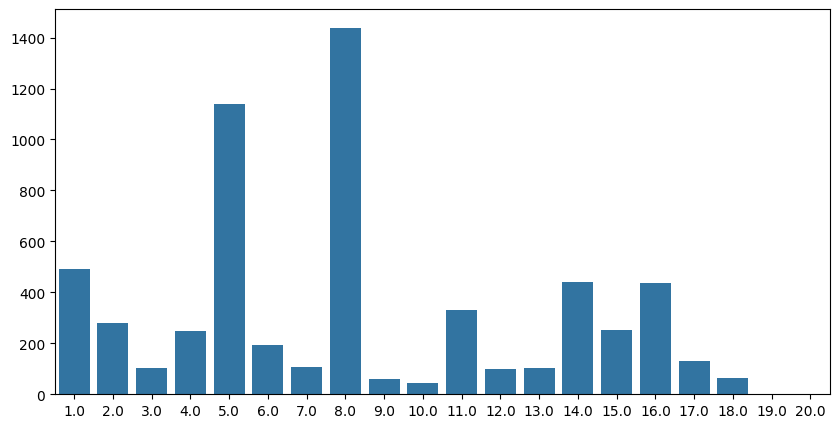

In [13]:
#Lets create a barplot to see the counts
plt.figure(figsize=(10,5))
sns.barplot(x=list(category_dict.keys()), y=list(category_dict.values()))

* As we can see from the plot, category 5 and 8 are dominating while 19 and 20 are nearly 0.
* Hence we can focus on the categories in the modelling phase.

## Customer Based Shoppings

In [14]:
df.groupby("User_ID")["Product_ID"].count()

User_ID
1000001     35
1000002     77
1000003     29
1000004     14
1000005    106
          ... 
1006036    514
1006037    122
1006038     12
1006039     74
1006040    180
Name: Product_ID, Length: 5891, dtype: int64

<Axes: xlabel='Product_ID', ylabel='Count'>

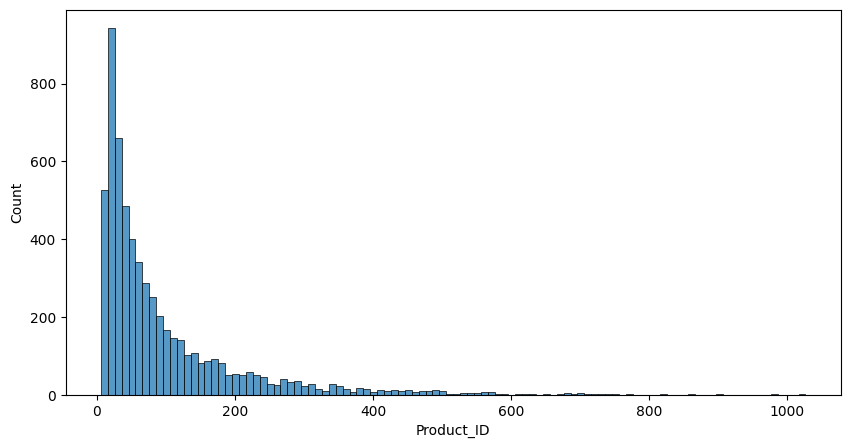

In [15]:
#Lets look at the histogram of customer based product shoppings
plt.figure(figsize=(10,5))
sns.histplot(df.groupby("User_ID")["Product_ID"].count())

* Maybe we can find products that are bought by more than some number of customers.

In [16]:
print("Best selling product:", df.groupby("Product_ID")["User_ID"].count().sort_values(ascending=False).index[0]);

Best selling product: P00265242


# Association Rule Mining

## Based on Customer-Product

Since there is no timestamp, I will use all of the shoppings for each user at same time.

In [17]:
#Lets create a database including only products and users
customer_product_df = df[["User_ID", "Product_ID"]]

In [18]:
customer_product_df.head()

,User_ID,Product_ID
0,1000001,P00069042
1,1000001,P00248942
2,1000001,P00087842
3,1000001,P00085442
4,1000002,P00285442


In [19]:
#Lets put product_ids on the columns
customer_product_df = customer_product_df.pivot(index="User_ID", columns="Product_ID", values="Product_ID")

In [20]:
#Lets one hot encode all products
customer_product_df.head()

Product_ID,P00000142,P00000242,P00000342,P00000442,P00000542,P00000642,P00000742,P00000842,P00000942,P00001042,...,P0098942,P0099042,P0099142,P0099242,P0099342,P0099442,P0099642,P0099742,P0099842,P0099942
User_ID,,,,,,,,,,,,,,,,,,,,,
1000001,P00000142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
#Lets change strings to true and nans to false
customer_product_df = customer_product_df.fillna(False)
customer_product_df = customer_product_df.astype(bool)

In [22]:
customer_product_df.head()

Product_ID,P00000142,P00000242,P00000342,P00000442,P00000542,P00000642,P00000742,P00000842,P00000942,P00001042,...,P0098942,P0099042,P0099142,P0099242,P0099342,P0099442,P0099642,P0099742,P0099842,P0099942
User_ID,,,,,,,,,,,,,,,,,,,,,
1000001,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1000002,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1000003,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1000004,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1000005,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [23]:
from mlxtend.frequent_patterns import apriori, association_rules

In [24]:
apriori(customer_product_df, min_support=0.1, use_colnames=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,support,itemsets
0,0.195553,(P00000142)
1,0.124767,(P00002142)
2,0.143269,(P00003242)
3,0.164318,(P00003442)
4,0.127143,(P00003942)
...,...,...
188,0.103208,"(P00057642, P00237542)"
189,0.102020,"(P00058042, P00265242)"
190,0.102869,"(P00265242, P00059442)"
191,0.113224,"(P00110742, P00112142)"


* Here we can see some products are bought with 10% of the time.

In [27]:
#Lets use fpgrowth
from mlxtend.frequent_patterns import fpgrowth

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
fpg = fpgrowth(customer_product_df, min_support=0.1, use_colnames=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
fpg

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,support,itemsets
0,0.274147,(P00025442)
1,0.244441,(P00184942)
2,0.238669,(P00059442)
3,0.234765,(P00255842)
4,0.231540,(P00117942)
...,...,...
188,0.102020,"(P00058042, P00265242)"
189,0.102869,"(P00278642, P00265242)"
190,0.102020,"(P00057642, P00145042)"
191,0.100153,"(P00145042, P00046742)"


**Difference from Apriori**:In particular, and what makes it different from the Apriori frequent pattern mining algorithm, FP-Growth is an frequent pattern mining algorithm that does not require candidate generation. Internally, it uses a so-called FP-tree (frequent pattern tree) datastrucure without generating the candidate sets explicitly, which makes it particularly attractive for large datasets.[1]

In [30]:
#Lastly lets look at association rules
from mlxtend.frequent_patterns import association_rules

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
association_rules(fpg, metric="confidence", min_threshold=0.4)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(P00059442),(P00265242),0.238669,0.319131,0.102869,0.431010,1.350574,0.026702,1.196627,0.340948
1,(P00110742),(P00025442),0.273638,0.274147,0.120014,0.438586,1.599819,0.044997,1.292901,0.516174
2,(P00025442),(P00110742),0.274147,0.273638,0.120014,0.437771,1.599819,0.044997,1.291933,0.516536
3,(P00110742),(P00112142),0.273638,0.265150,0.113224,0.413772,1.560518,0.040668,1.253522,0.494501
4,(P00112142),(P00110742),0.265150,0.273638,0.113224,0.427017,1.560518,0.040668,1.267685,0.488790
5,(P00112142),(P00025442),0.265150,0.274147,0.107113,0.403969,1.473550,0.034422,1.217811,0.437323
6,(P00057642),(P00110742),0.249533,0.273638,0.101171,0.405442,1.481675,0.032890,1.221685,0.433181
7,(P00057642),(P00046742),0.249533,0.244101,0.102190,0.409524,1.677681,0.041278,1.280151,0.538250
8,(P00046742),(P00057642),0.244101,0.249533,0.102190,0.418637,1.677681,0.041278,1.290875,0.534382
9,(P00058042),(P00265242),0.241385,0.319131,0.102020,0.422644,1.324360,0.024987,1.179289,0.322849


Here I am only interested in above 40% confidence level. And here are 16 possible suggestions regarding products. Such as if somebody got (P00059442) then with 23% he will buy (P00265242).

## Based on Category and User

In [40]:
#Lets create a user and category of users that shopped
user_category_df = df[["User_ID", "Product_Category_1"]]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
user_category_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,User_ID,Product_Category_1
0,1000001,3
1,1000001,1
2,1000001,12
3,1000001,12
4,1000002,8


In [42]:
user_category_df.set_index("User_ID", inplace=True)
user_category_df = pd.get_dummies(user_category_df, columns=["Product_Category_1"])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
user_category_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Product_Category_1_1,Product_Category_1_2,Product_Category_1_3,Product_Category_1_4,Product_Category_1_5,Product_Category_1_6,Product_Category_1_7,Product_Category_1_8,Product_Category_1_9,Product_Category_1_10,Product_Category_1_11,Product_Category_1_12,Product_Category_1_13,Product_Category_1_14,Product_Category_1_15,Product_Category_1_16,Product_Category_1_17,Product_Category_1_18,Product_Category_1_19,Product_Category_1_20
User_ID,,,,,,,,,,,,,,,,,,,,
1000001,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1000001,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1000001,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
1000001,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
1000002,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False


In [44]:
#Lets aggregate on index
user_category_df = user_category_df.groupby(user_category_df.index).sum()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
user_category_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Product_Category_1_1,Product_Category_1_2,Product_Category_1_3,Product_Category_1_4,Product_Category_1_5,Product_Category_1_6,Product_Category_1_7,Product_Category_1_8,Product_Category_1_9,Product_Category_1_10,Product_Category_1_11,Product_Category_1_12,Product_Category_1_13,Product_Category_1_14,Product_Category_1_15,Product_Category_1_16,Product_Category_1_17,Product_Category_1_18,Product_Category_1_19,Product_Category_1_20
User_ID,,,,,,,,,,,,,,,,,,,,
1000001,4,1,11,2,2,1,0,8,0,0,0,3,0,1,0,1,0,0,0,1
1000002,31,1,0,0,13,6,0,25,0,0,0,0,0,0,0,0,0,0,0,1
1000003,15,2,1,0,9,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1000004,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1000005,18,2,1,3,20,6,5,44,0,0,2,0,0,1,1,3,0,0,0,0


In [46]:
#Last step is to change dtype to boolean
user_category_df = user_category_df.astype(bool)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


10% of the time 1,5 and 8 no categories are bought by each customer.

In [51]:
cat_user = apriori(user_category_df, min_support=0.1, use_colnames=True)
cat_user

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,support,itemsets
0,0.978951,(Product_Category_1_1)
1,0.729248,(Product_Category_1_2)
2,0.651502,(Product_Category_1_3)
3,0.570531,(Product_Category_1_4)
4,0.976235,(Product_Category_1_5)


We have a much more insight than product based one. And I will not try fpg since they are pretty similar.

In [56]:
ass_cat_df = association_rules(cat_user, metric="confidence", min_threshold=0.97)
ass_cat_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Product_Category_1_2),(Product_Category_1_1),0.729248,0.978951,0.721779,0.989758,1.011039,0.007881,2.055153,0.040328
1,(Product_Category_1_3),(Product_Category_1_1),0.651502,0.978951,0.642336,0.985930,1.007129,0.004547,1.496042,0.020312
2,(Product_Category_1_4),(Product_Category_1_1),0.570531,0.978951,0.564930,0.990181,1.011472,0.006407,2.143815,0.026409
3,(Product_Category_1_1),(Product_Category_1_5),0.978951,0.976235,0.956035,0.976591,1.000365,0.000349,1.015208,0.017319
4,(Product_Category_1_5),(Product_Category_1_1),0.976235,0.978951,0.956035,0.979308,1.000365,0.000349,1.017253,0.015340
...,...,...,...,...,...,...,...,...,...,...
57804,"(Product_Category_1_11, Product_Category_1_4, ...","(Product_Category_1_8, Product_Category_1_1, P...",0.119165,0.693770,0.118316,0.992877,1.431133,0.035643,42.994670,0.342008
57805,"(Product_Category_1_11, Product_Category_1_4, ...","(Product_Category_1_8, Product_Category_1_1, P...",0.119504,0.667629,0.118316,0.990057,1.482946,0.038532,33.427068,0.369867
57806,"(Product_Category_1_11, Product_Category_1_4, ...","(Product_Category_1_8, Product_Category_1_1, P...",0.120353,0.541843,0.118316,0.983075,1.814315,0.053104,27.069414,0.510236
57807,"(Product_Category_1_16, Product_Category_1_4, ...","(Product_Category_1_8, Product_Category_1_1, P...",0.121372,0.588016,0.118316,0.974825,1.657822,0.046948,16.364935,0.451612


In [59]:
#Lets look at the together shopped list
ass_cat_df.sort_values(by="antecedents", ascending=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
39722,"(Product_Category_1_11, Product_Category_1_7, ...",(Product_Category_1_1),0.106773,0.978951,0.106773,1.000000,1.021502,0.002247,inf,0.023565
38604,"(Product_Category_1_11, Product_Category_1_4, ...",(Product_Category_1_1),0.100662,0.978951,0.100662,1.000000,1.021502,0.002119,inf,0.023405
38522,"(Product_Category_1_16, Product_Category_1_4, ...","(Product_Category_1_8, Product_Category_1_6, P...",0.107622,0.544729,0.104397,0.970032,1.780759,0.045772,15.191666,0.491318
38526,"(Product_Category_1_11, Product_Category_1_4, ...",(Product_Category_1_2),0.101341,0.729248,0.100832,0.994975,1.364385,0.026929,53.879647,0.297186
38527,"(Product_Category_1_11, Product_Category_1_4, ...",(Product_Category_1_6),0.102020,0.693431,0.100832,0.988353,1.425309,0.030088,26.321168,0.332299
...,...,...,...,...,...,...,...,...,...,...
19376,"(Product_Category_1_20, Product_Category_1_13,...","(Product_Category_1_8, Product_Category_1_1)",0.121711,0.941097,0.120862,0.993026,1.055180,0.006320,8.446749,0.059541
19377,"(Product_Category_1_3, Product_Category_1_2, P...","(Product_Category_1_8, Product_Category_1_1, P...",0.121711,0.921745,0.120862,0.993026,1.077333,0.008676,11.221762,0.081729
19379,"(Product_Category_1_16, Product_Category_1_8, ...",(Product_Category_1_1),0.103378,0.978951,0.103378,1.000000,1.021502,0.002176,inf,0.023476
19381,"(Product_Category_1_16, Product_Category_1_8, ...","(Product_Category_1_1, Product_Category_1_5)",0.103378,0.956035,0.103378,1.000000,1.045987,0.004545,inf,0.049034


Here we have much more possible decisions with over 97% confidence level, but we should not forget. These are aggregated upon all category based shoppings for all customers. Hence, the noise is probably too much in this way of using. But I guess it is more similar to a basket market analysis this way since we only have 20 objects and many customers.